In [ ]:
%pip install pandas numpy matplotlib seaborn scikit-learn


#### 1. Carga y Limpieza de Datos

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA



df = pd.read_csv('data/AFECTACI_N_DE_MIEMBROS_DE_LA_FUERZA_P_BLICA_20250616.csv', encoding='utf-8')
df['FECHA HECHO'] = pd.to_datetime(df['FECHA HECHO'], format='%d/%m/%Y')
df['CANTIDAD'] = df['CANTIDAD'].fillna(0)


#### 2. Comprensión y Preparación de los Datos

In [20]:

df['AÑO'] = df['FECHA HECHO'].dt.year
df['SEMESTRE'] = np.where(df['FECHA HECHO'].dt.month <= 6, 1, 2)
df['PERIODO'] = df['AÑO'].astype(str) + "-S" + df['SEMESTRE'].astype(str)

# Agrupar por DEPARTAMENTO, PERIODO y ACCION
df_grouped = df.groupby(['DEPARTAMENTO', 'PERIODO', 'ACCION'])['CANTIDAD'].sum().unstack(fill_value=0).reset_index()

# Asegurar existencia de ambas columnas
for col in ['HERIDO', 'ASESINADO']:
    if col not in df_grouped.columns:
        df_grouped[col] = 0


#### 3. Transformación para Modelado

In [21]:
# Agrupar totales por departamento
df_pivot = df_grouped.groupby('DEPARTAMENTO')[['HERIDO', 'ASESINADO']].sum()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot)


#### 4. Modelado - Clustering con KMeans

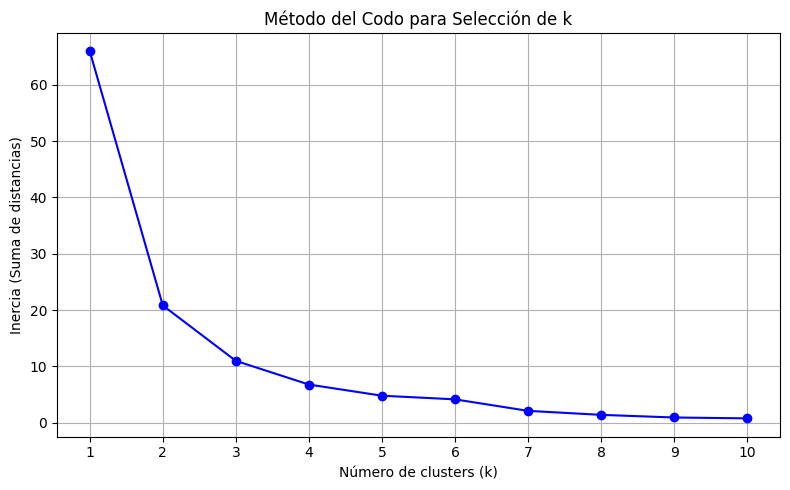

In [ ]:
# Método del codo para elegir el número óptimo de clusters
inertias = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

# Gráfica del codo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Suma de distancias)')
plt.title('Método del Codo para Selección de k')
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()



In [28]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df_pivot['CLUSTER'] = clusters


 #### 5. Reducción Dimensional - PCA

In [23]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

#### 6. Visualización del Clustering

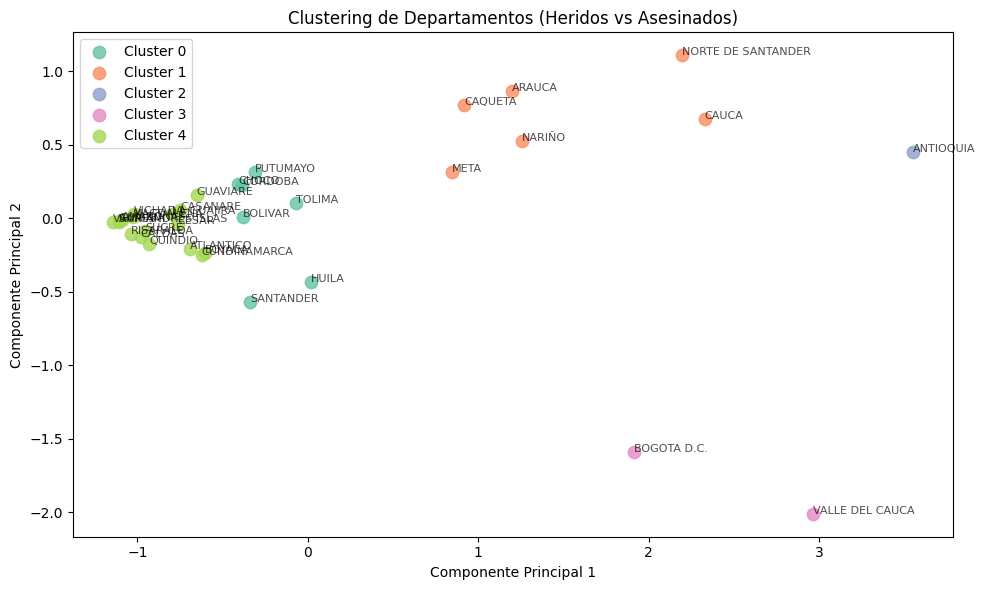

In [24]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2", k)
for i in range(k):
    plt.scatter(X_pca[clusters == i, 0], X_pca[clusters == i, 1], 
                label=f'Cluster {i}', s=80, alpha=0.8, color=palette[i])
for i, dep in enumerate(df_pivot.index):
    plt.text(X_pca[i, 0], X_pca[i, 1], dep, fontsize=8, alpha=0.7)
plt.title("Clustering de Departamentos (Heridos vs Asesinados)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.tight_layout()
plt.show()


#### 7. Análisis Temporal - Mapas de Calor

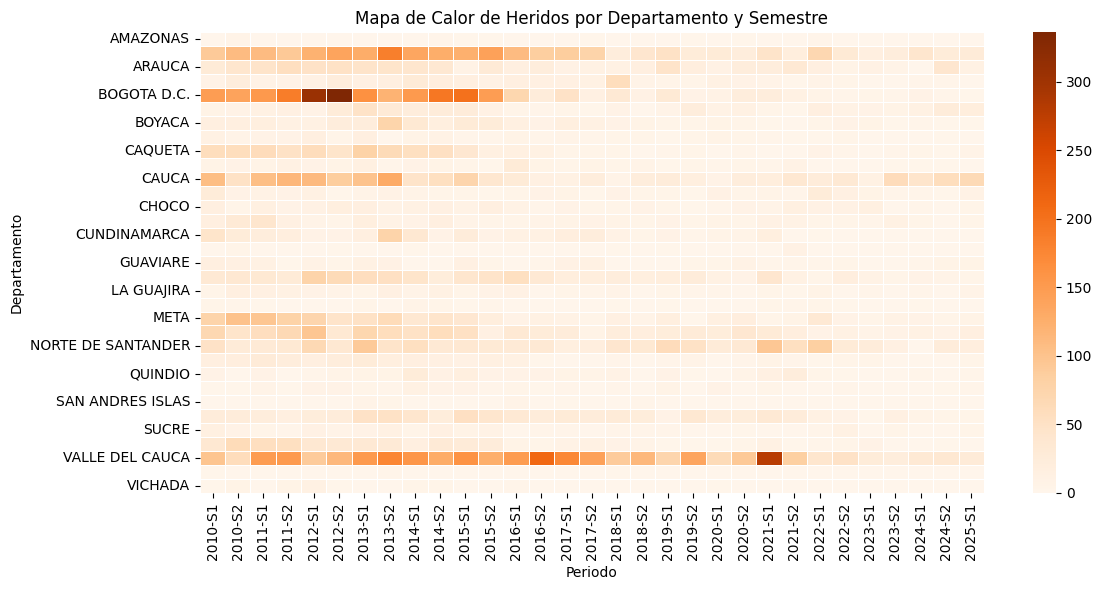

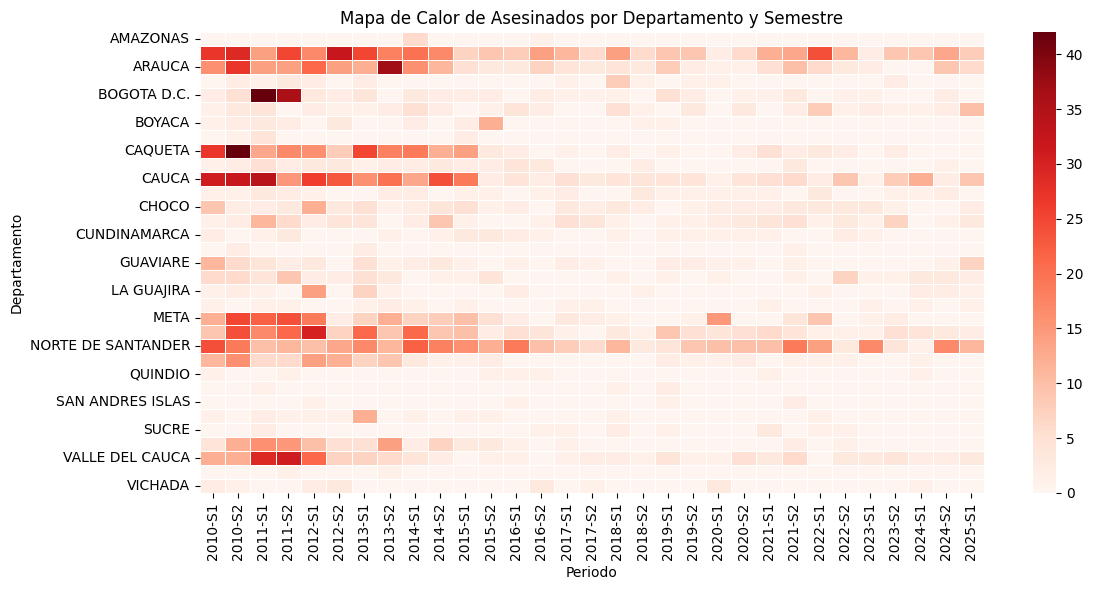

In [25]:
# Heatmap de Heridos
heatmap_heridos = df_grouped.pivot(index='DEPARTAMENTO', columns='PERIODO', values='HERIDO').fillna(0)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_heridos, cmap="Oranges", linewidths=0.5)
plt.title("Mapa de Calor de Heridos por Departamento y Semestre")
plt.xlabel("Periodo")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

# Heatmap de Asesinados
heatmap_asesinados = df_grouped.pivot(index='DEPARTAMENTO', columns='PERIODO', values='ASESINADO').fillna(0)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_asesinados, cmap="Reds", linewidths=0.5)
plt.title("Mapa de Calor de Asesinados por Departamento y Semestre")
plt.xlabel("Periodo")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()


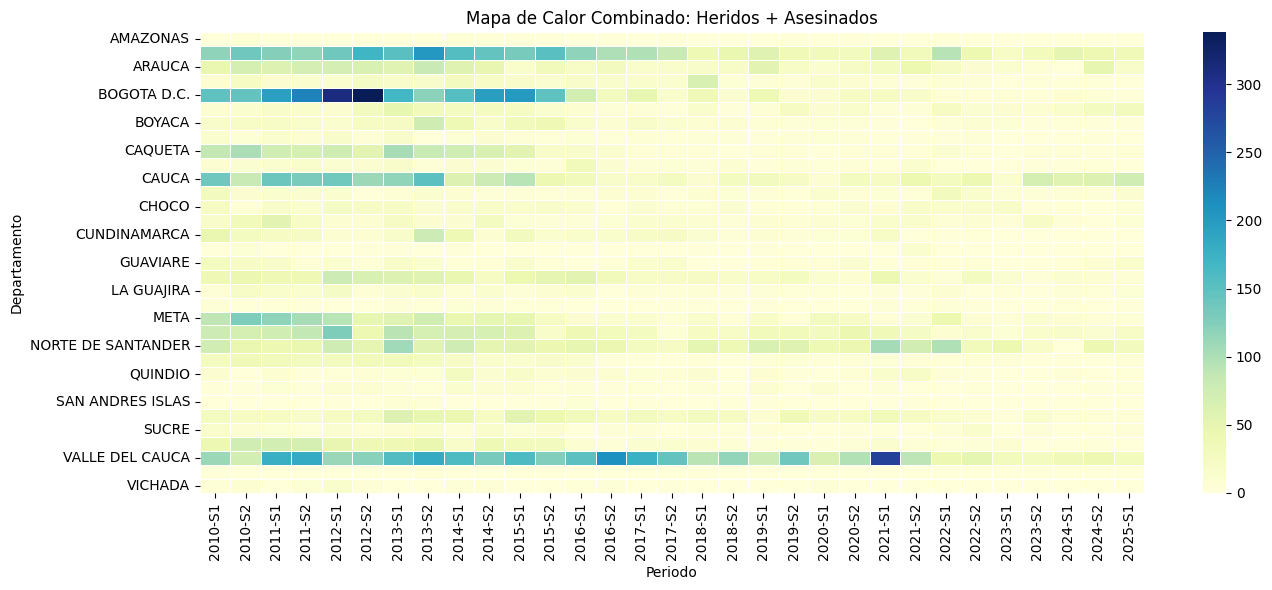

In [26]:
# Combinar valores de heridos y asesinados por departamento y periodo
df_grouped['TOTAL'] = df_grouped['HERIDO'] + df_grouped['ASESINADO']


heatmap_total = df_grouped.pivot(index='DEPARTAMENTO', columns='PERIODO', values='TOTAL').fillna(0)

# Mapa de calor combinado - Explicar posible corrupción de datos
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_total, cmap="YlGnBu", linewidths=0.5)
plt.title("Mapa de Calor Combinado: Heridos + Asesinados")
plt.xlabel("Periodo")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()


#### 8. Resultados Finales y Análisis

In [27]:
print("\n=== Departamentos agrupados por riesgo ===")
resultado = df_pivot[['HERIDO', 'ASESINADO', 'CLUSTER']].reset_index().sort_values(by='CLUSTER')
print(resultado)



=== Departamentos agrupados por riesgo ===
ACCION        DEPARTAMENTO  HERIDO  ASESINADO  CLUSTER
17                   HUILA     887         64        0
23                PUTUMAYO     285         98        0
13                 CORDOBA     293         85        0
5                  BOLIVAR     418         67        0
29                  TOLIMA     538        101        0
12                   CHOCO     278         83        0
27               SANTANDER     765         23        0
10                   CAUCA    1559        344        1
22      NORTE DE SANTANDER    1242        369        1
21                  NARIÑO    1044        244        1
20                    META     929        193        1
2                   ARAUCA     820        267        1
8                  CAQUETA     718        236        1
1                ANTIOQUIA    2363        426        2
4              BOGOTA D.C.    2589        124        3
30         VALLE DEL CAUCA    3413        176        3
26        SAN ANDRES 